# Analyzing `@LADOTofficial`'s tweets

LADOT uses a social media manager called __Hootsuite__ that integrates all social media accounts (Twitter, Facebook, Instagram) in one place:<br>
__Hootsuite__ https://www.youtube.com/watch?v=Ztk6PXD1EjU

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set()

import json
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
import sys

sys.path.insert(1, 'src/')
import acquire

## Wrangle

Created a new column called `total_engagement` which is a summation of retweets, replies, likes, and quote counts for each tweet.

In [2]:
df = acquire.get_twitter_data()

print(df.shape)
df.head()

(172, 11)


,post_time,id,name,username,tweet,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
0,2020-09-30 16:02:18+00:00,61261275,Los Angeles Department of Transportation,LADOTofficial,a new bus-only lane is making its debut in #do...,27,9,111,8,1311335571097300996,155
1,2020-09-30 17:37:02+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @bsslosangeles: what a difference it makes ...,3,0,0,0,1311359411806375936,3
2,2020-09-30 17:37:59+00:00,341250146,Joe Buscaino,JoeBuscaino,rt @losangeleswalks: safe streets organizing t...,3,0,0,0,1311359653037527040,3
3,2020-09-30 18:57:42+00:00,17070113,Eric Garcetti,MayorOfLA,rt @citylajobs: the city of la offers an onlin...,17,0,0,0,1311379712439058432,17
4,2020-09-30 19:10:52+00:00,893602974,"Curren D. Price, Jr.",CurrenDPriceJr,i partnered with guardaheart to bring crucial ...,0,0,1,1,1311383024559218688,2


In [3]:
# No missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   post_time         172 non-null    object
 1   id                172 non-null    int64 
 2   name              172 non-null    object
 3   username          172 non-null    object
 4   tweet             172 non-null    object
 5   retweet_count     172 non-null    int64 
 6   reply_count       172 non-null    int64 
 7   like_count        172 non-null    int64 
 8   quote_count       172 non-null    int64 
 9   tweet_url_id      172 non-null    int64 
 10  total_engagement  172 non-null    int64 
dtypes: int64(7), object(4)
memory usage: 14.9+ KB


Looking at descriptive statistics of the tweets, most features are skewed to the left.

In [4]:
df.describe(include=np.number)

,id,retweet_count,reply_count,like_count,quote_count,tweet_url_id,total_engagement
count,1.720000e+02,172.000000,172.000000,172.000000,172.000000,1.720000e+02,172.000000
mean,1.150536e+08,911.831395,55.186047,325.610465,20.488372,1.313716e+18,1313.116279
std,2.299233e+08,10760.995030,256.603319,1341.121131,157.049830,1.647203e+15,10933.205177
min,1.707011e+07,0.000000,0.000000,0.000000,0.000000,1.311336e+18,0.000000
25%,1.707011e+07,2.000000,0.000000,0.000000,0.000000,1.312118e+18,6.000000
50%,1.707011e+07,14.000000,2.500000,7.500000,0.000000,1.313890e+18,34.000000
75%,6.126128e+07,37.250000,33.250000,104.250000,4.250000,1.314982e+18,206.250000
max,9.567633e+08,141061.000000,3156.000000,11722.000000,2015.000000,1.316485e+18,141061.000000


- Eric Garcetti tweeted the most with 100 tweets during the two week period.
- There are 5 twitter accounts in the dataset.
- There were 172 tweets created during the outreach period.

In [5]:
df.describe(exclude=np.number)

,post_time,name,username,tweet
count,172,172,172,172
unique,167,5,5,172
top,2020-10-01 00:40:26+00:00,Eric Garcetti,MayorOfLA,se han instalado cajas de entrega de boletas e...
freq,2,100,100,1


In [6]:
# Create a new column that indicates a tweet contains the string 'parking enforcement'
df['is_parking_enforcement'] = np.where(df.tweet.str.contains('parking enforcement', case=False), 1, 0)
df = df.drop(columns=['id', 'tweet_url_id'])

In [7]:
# Create a separate dataframe for LADOT tweets
LADOT_tweets = df.loc[df.username == 'LADOTofficial'].reset_index(drop=True)

In [8]:
# Create two datasets for tweets related to parking enforcement and non-related to parking enforcement
non_enforcement_tweets = df.loc[~df.tweet.str.contains('parking enforcement')]
enforcement_tweets = df.loc[df.tweet.str.contains('parking enforcement')]

# Set the index of both datasets to a datetime index for visualizations
non_enforcement_metrics = non_enforcement_tweets[['post_time', 'total_engagement']]
enforcement_metrics = enforcement_tweets[['post_time', 'total_engagement']]

non_enforcement_metrics.set_index('post_time', inplace=True)
enforcement_metrics.set_index('post_time', inplace=True)

non_enforcement_metrics.index = pd.to_datetime(non_enforcement_metrics.index)
enforcement_metrics.index = pd.to_datetime(enforcement_metrics.index)

In [9]:
# Resample the datetime index to calculate the total engagement generated for each date.
enforcement_metrics = enforcement_metrics.resample('D').sum()
non_enforcement_metrics = non_enforcement_metrics.resample('D').sum()

# Exploration

In this section, we'll look at the total engagement generated by city officials and LADOT during the two week outreach period, September 30th - October 14th of 2020.
- How many tweets mentioned 'parking enforcement'?
- Who mentioned 'parking enforcement' on Twitter the most?
- Who conducted the most public outreach as measured by `total_engagement`?

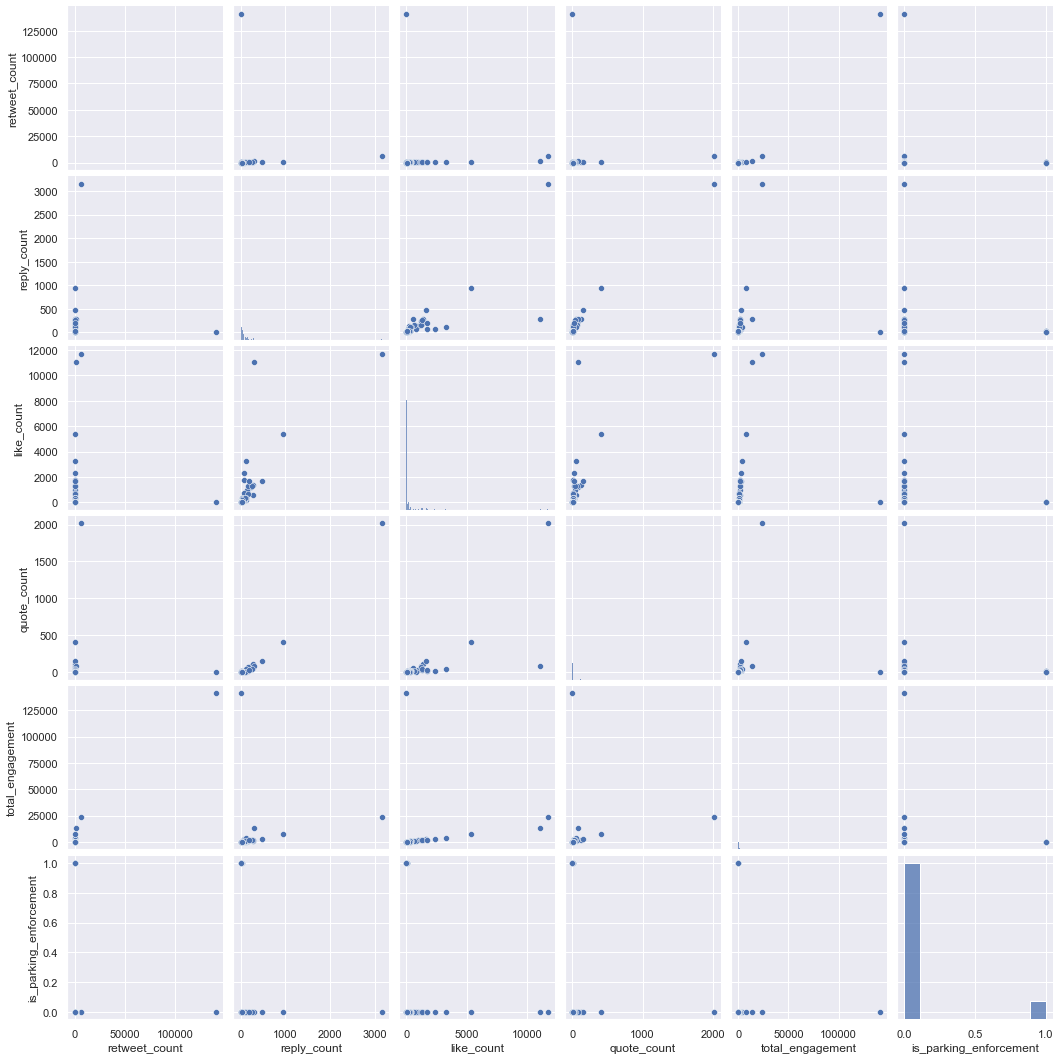

In [10]:
# Create a pairplot to visualize interactions between numeric variables.
sns.pairplot(df);

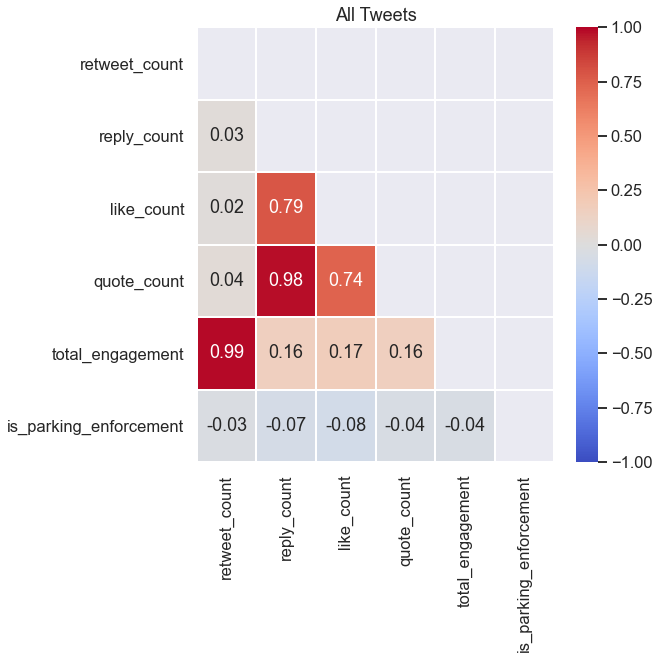

In [11]:
df_corrs = df.corr()
mask = np.zeros_like(df_corrs)
mask[np.triu_indices_from(mask)] = True

sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            vmax=1,
            vmin=-1,
            mask=mask)

plt.title('All Tweets')
plt.margins(y=20);

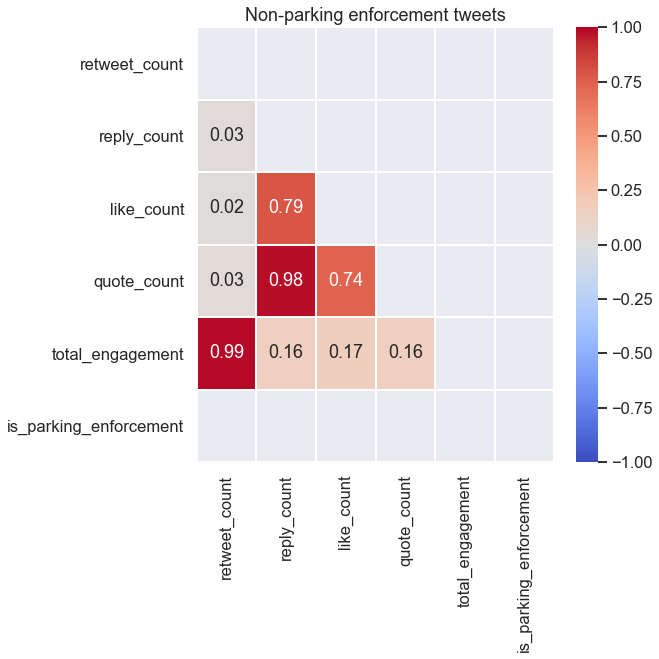

In [12]:
sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(non_enforcement_tweets.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            mask=mask,
            vmax=1,
            vmin=-1)

plt.title('Non-parking enforcement tweets');

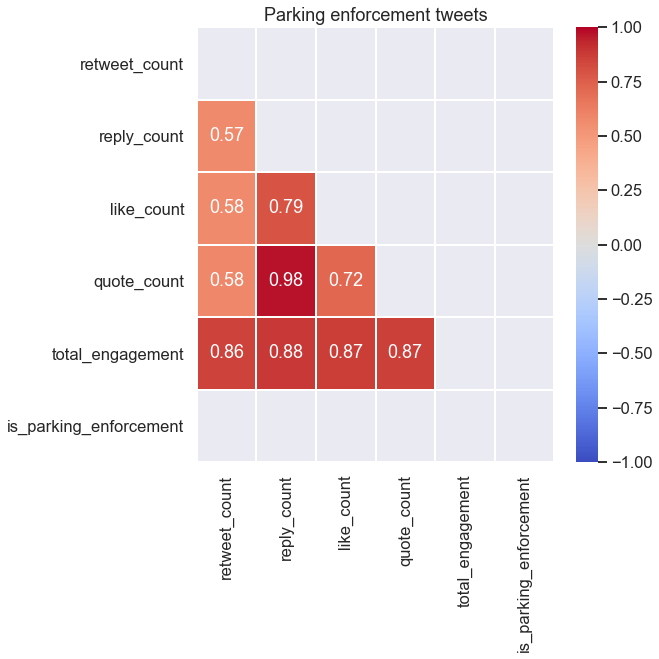

In [13]:
sns.set_context('talk')

plt.figure(figsize=(8, 8))
sns.heatmap(enforcement_tweets.corr(),
            linewidths=1,
            annot=True,
            cmap='coolwarm',
            mask=mask,
            vmax=1,
            vmin=-1)

plt.title('Parking enforcement tweets')
plt.margins(10);

## LADOT's Tweets

In [23]:
print(f"There were {LADOT_tweets.is_parking_enforcement.count()} tweets related to Parking Enforcement")
LADOT_tweets.is_parking_enforcement.value_counts(normalize=True)

There were 46 tweets related to Parking Enforcement


0    0.673913
1    0.326087
Name: is_parking_enforcement, dtype: float64

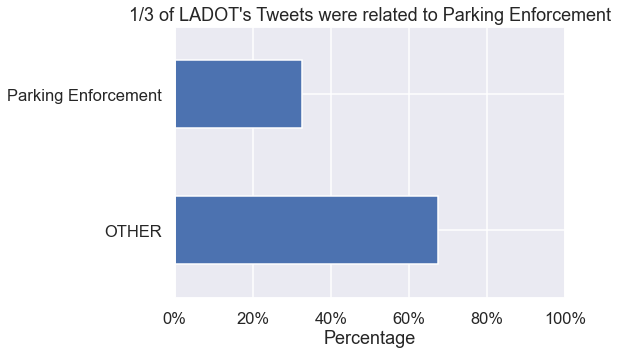

In [15]:
LADOT_tweets.is_parking_enforcement.value_counts(normalize=True).plot.barh(figsize=(7, 5))

plt.title("1/3 of LADOT's Tweets were related to Parking Enforcement")
plt.xlabel('Percentage')

plt.yticks(labels=['OTHER', 'Parking Enforcement'], ticks=[0, 1])
plt.xticks(np.linspace(0, 1, 6), labels=[f'{i:0.0%}' for i in np.linspace(0, 1, 6)]);

## Comparing parking enforcement to non-parking enforcement tweets

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


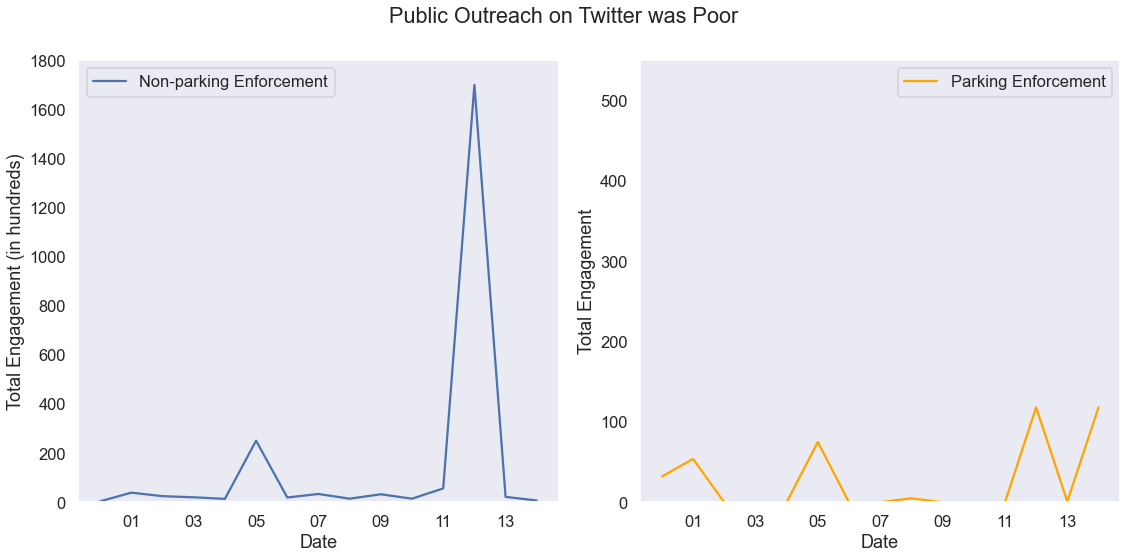

In [16]:
sns.set_context('talk')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking Enforcement',
             color='orange',
             ax=ax2)

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking Enforcement',
             ax=ax1)

ax1.grid()
ax2.grid()

ax1.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=2, maxticks=15))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%d"))
plt.setp(ax1.get_xticklabels(), rotation=0, ha="center")

ax2.get_xaxis().set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=15))
ax2.get_xaxis().set_major_formatter(mdates.DateFormatter("%d"))
plt.setp(ax2.get_xticklabels(), rotation=0, ha="center")

ax1.set_ylim(0, 180_000)
ax2.set_ylim(0, 550)

ax1.set_xlabel('Date')
ax2.set_xlabel('Date')

ax1.set_ylabel('Total Engagement (in hundreds)')
ax2.set_ylabel('Total Engagement')

ax1.set_yticklabels(labels=[str(i) for i in range(0, 1801, 200)])

plt.suptitle('Public Outreach on Twitter was Poor')
plt.tight_layout();

## Who mentioned parking enforcement the most?

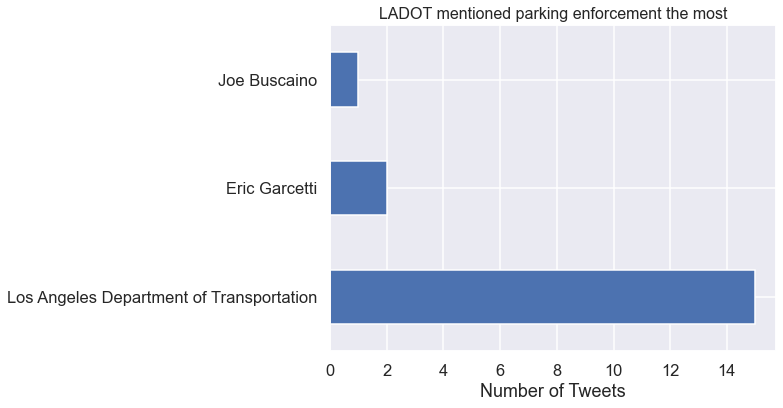

In [17]:
sns.set_context('talk')
enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh(figsize=(8, 6))

plt.title('LADOT mentioned parking enforcement the most', fontsize=16)
plt.xlabel('Number of Tweets')
plt.ylabel('');

## Who conducted the most public outreach?

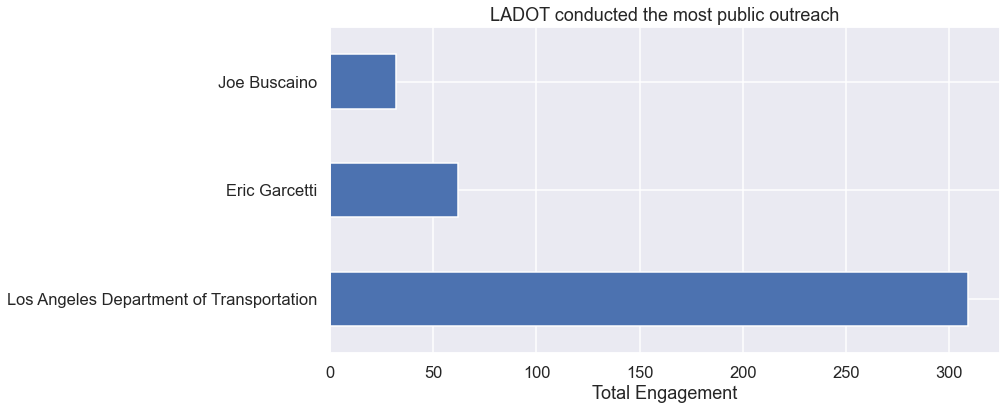

In [18]:
sns.set_context('talk')
enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh(figsize=(12, 6))

plt.title('LADOT conducted the most public outreach', fontsize=18)
plt.xlabel('Total Engagement')
plt.ylabel('');

# Conclusions

During the period of 09-30-2020 to 10-15-2020, LADOT mentioned 'parking enforcement' the most. LADOT conducted the most public outreach compared to other City Officials.

# Appendix

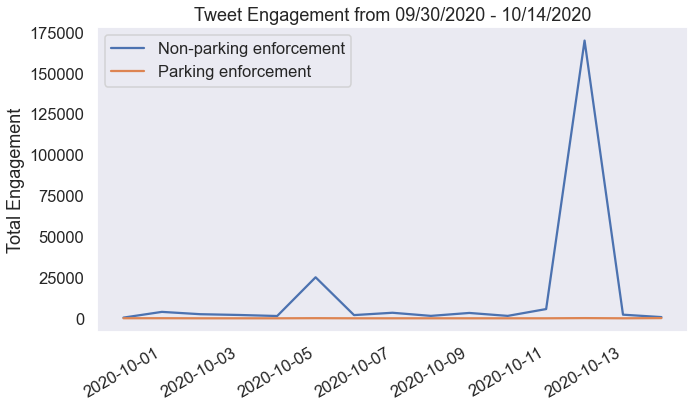

In [19]:
sns.set_context('talk')
plt.figure(figsize=(10, 6))

sns.lineplot(data=non_enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Non-parking enforcement')


sns.lineplot(data=enforcement_metrics,
             x='post_time',
             y='total_engagement',
             label='Parking enforcement')


plt.title("Tweet Engagement from 09/30/2020 - 10/14/2020")
plt.xlabel('')
plt.ylabel('Total Engagement')

plt.xticks(rotation=30, ha="right")

plt.grid()
plt.tight_layout();

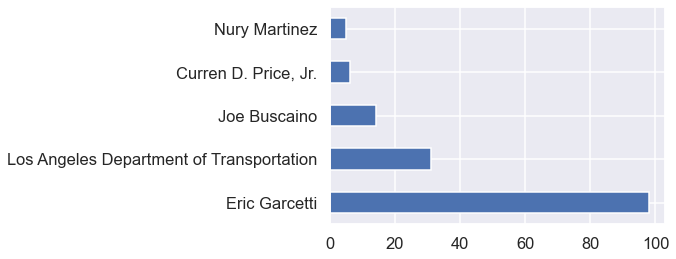

In [20]:
# Tweets unrelated to parking enforcement: Number of Tweets generated
non_enforcement_tweets.groupby('name').size().sort_values(ascending=False).plot.barh()
plt.ylabel('');

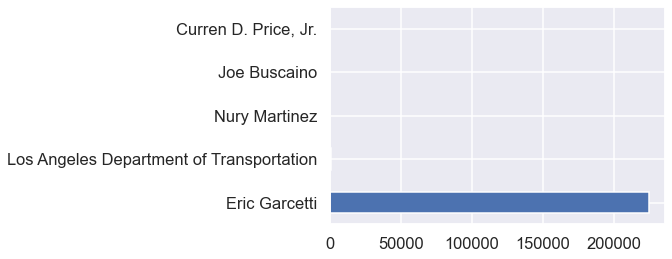

In [21]:
# Tweets unrelated to parking enforcement: Total engagement
non_enforcement_tweets.groupby('name').total_engagement.sum().sort_values(ascending=False).plot.barh()
plt.ylabel('');

## Which words were used the most?

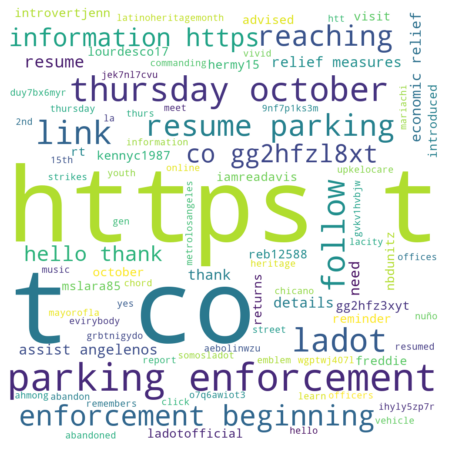

In [22]:
sentence = ' '.join(enforcement_tweets.tweet)

plt.figure(figsize=(8, 8))

img = WordCloud(background_color='white',
                stopwords=STOP_WORDS,
                width=1000,
                height=1000
               ).generate(sentence)

plt.imshow(img, interpolation="bilinear")

plt.axis('off');